In [1]:
import folium
import geopy.distance
import geojson
import json
import urllib.request
import itertools
import pandas as pd
import numpy as np
import branca

In [2]:
def km_del_bondi(línea):
    import geopy.distance
    l_suma=0
    for i in range(len(línea)-1):
        l_suma = l_suma + geopy.distance.distance(línea[i], línea[i+1]).km
    return l_suma

In [3]:
def intervals(minimo, maximo, k):
    interv=[]
    intervalos=[]
    import math as mt
    k_intervals = mt.modf(1+3.322*np.log10(k))[1]
    rango = (maximo-minimo)/k_intervals
    num = minimo
    for i in np.arange(k_intervals):
        interv= np.append(interv, num)
        num_rango= num + rango
        interv= np.append(interv, num_rango)
        num = num_rango
       
    interv = interv.reshape(int(k_intervals), 2)        
    for i in np.arange(len(interv)):
        pandas_interv = pd.Interval(round(interv[i:i+1, 0:].item(0)), 
                                    round(interv[i:i+1, 0:].item(1)), 
                                    closed='left')
        intervalos = np.append(intervalos, pandas_interv)
    return intervalos

In [4]:
def freq_intervals(var_N, intervals):
    n_interv = 0*np.arange(len(intervals))
    for i in np.arange(len(var_N)):
        for a in np.arange(len(intervals)):
            if var_N[i] in intervals[a]:
                n_interv[a] = n_interv[a]+1
    return n_interv

In [5]:
def tabla_interv_freq(variable):
    minimo = variable.describe()[3].item()
    maximo = variable.describe()[7].item()+1
    k = len(variable)
    calc_intervalos= intervals(minimo, maximo, k)
    fi=freq_intervals(variable, calc_intervalos)
    prob=[]
    for i in np.arange(len(fi)):
        prob=np.append(prob, round(fi[i]/len(variable), 2))
      
    tabla_inter_freq = pd.DataFrame({'Intervalos' : calc_intervalos,
                                          'Frecuencia' : fi,
                                          'Probabilidades' : prob})
    
    return tabla_inter_freq

In [6]:
df_colectivos_stafe = pd.read_csv(r'C:\Users\Mauricio\Documents\jupyter\subsidios\colectivos santafe.csv', sep=';', encoding='latin1')
df_colectivos_stafe.drop('Unnamed: 0', axis=1, inplace=True)

In [7]:
matriz_barrios_kmcolectivos = pd.read_csv(r'C:\Users\Mauricio\Documents\jupyter\subsidios\km recorridos por colectivo por barrio.csv', sep=';', encoding='latin1')
matriz_barrios_kmcolectivos.drop('Unnamed: 0', axis=1, inplace=True)

In [8]:
lineas_recorrido_gj = r'C:\Users\Mauricio\Documents\jupyter\subsidios\recorrido_lineas_TUP_stafe.geojson'
lr_geojson = json.load(open(lineas_recorrido_gj))

In [9]:
lr_geojson['features'][14]['geometry']['coordinates']

[[-31.633662, -60.705458],
 [-31.633033, -60.705226],
 [-31.632431, -60.704969],
 [-31.631825, -60.704868],
 [-31.61488, -60.705356],
 [-31.607382, -60.703706],
 [-31.603759, -60.702456],
 [-31.603759, -60.702456]]

In [11]:
barrios_poblacion = pd.read_csv(r'C:\Users\Mauricio\Documents\jupyter\subsidios\poblacion barrios.csv', sep=';', encoding='latin1')
barrios_poblacion.drop('Unnamed: 0', axis=1, inplace=True)
#Tabla de intervalos de densidad poblacional y población total (ver final del nb para consultar las funciones)
intervalos_dens = tabla_interv_freq(barrios_poblacion['Densidad poblacional m2'])
intervalos = tabla_interv_freq(barrios_poblacion['Poblacion'])

In [12]:
def piste_style_function(feature):
    if feature['properties']['pob'] in intervalos['Intervalos'][0]:
        color= '#FFCC99'
    elif feature['properties']['pob'] in intervalos['Intervalos'][1]:
        color = '#FFB266'
    elif feature['properties']['pob'] in intervalos['Intervalos'][2]:
        color = '#FF9933'
    elif feature['properties']['pob'] in intervalos['Intervalos'][3]:
        color = '#FF8000'
    elif feature['properties']['pob'] in intervalos['Intervalos'][4]:
        color = '#CC6600'
    elif feature['properties']['pob'] in intervalos['Intervalos'][5]:
        color = '#994C00'
    elif feature['properties']['pob'] in intervalos['Intervalos'][6]:
        color = '#663300'
    return {'FillOpacity': 0.3, 
            'weight': 0.2,
            'color': color}

In [13]:
def piste_style_function_density(feature):
    if feature['properties']['dens'] in intervalos_dens['Intervalos'][0]:
        color= '#99CCFF'
    elif feature['properties']['dens'] in intervalos_dens['Intervalos'][1]:
        color = '#66B2FF'
    elif feature['properties']['dens'] in intervalos_dens['Intervalos'][2]:
        color = '#3399FF'
    elif feature['properties']['dens'] in intervalos_dens['Intervalos'][3]:
        color = '#0080FF'
    elif feature['properties']['dens'] in intervalos_dens['Intervalos'][4]:
        color = '#0066CC'
    elif feature['properties']['dens'] in intervalos_dens['Intervalos'][5]:
        color = '#004C99'
    elif feature['properties']['dens'] in intervalos_dens['Intervalos'][6]:
        color = '#003366'
    return {'FillOpacity': 0.3, 
            'weight': 0.2,
            'color': color}

In [14]:
pob_color = ['#FFCC99', '#FFB266', '#FF9933', '#FF8000', '#CC6600', '#994C00', '#663300']
dens_color = ['#99CCFF', '#66B2FF', '#3399FF', '#0080FF', '#0066CC', '#004C99', '#003366']

In [15]:
santafe_geojson = r'C:\Users\Mauricio\Documents\jupyter\subsidios\Santefe-Barrios-3.geojson'
#sta_gj_data = json.loads(santafe_geojson)
with open(santafe_geojson, "r") as infile:
    stafe_barrios_vectores = json.loads(infile.read())


In [16]:
#JSON SAVE:
#santafe_geojson_2save = stafe_barrios_vectores
#with open(santafe_geojson, 'w') as fp:
#    json.dump(santafe_geojson_2save, fp)

## Análisis de los recorridos de los colectivos en la Ciudad de Santa Fe

##### Según la municipalidad de la Ciudad de Santa Fe, al año 2016 hay una flota activa de 201 colectivos. La cantidad de líneas es 17 (de la 1 a la 21, junto al Ronda B), por lo cual se obtienen 11.8 coches por línea. Con la información de los recorridos obtenidos a través del portal web de la municipalidad, del ¿Cuándo Pasa?, y de las webs de las empresas podemos obtener los siguientes recorridos de ida y vuelta para las siguientes líneas: 1, 2, 3, 4, 5, 8, 9, 10, 11, 13, 14, 15, 16 y 18 (20 y 21 funcionan con frecuencias diferentes a las del resto de las líneas).

In [17]:
mapa = folium.Map(location=[-31.626214, -60.707501], tiles='cartodbpositron', zoom_start=12)

#### Mapa 1. Trayecto de colectivos: población por barrio

In [18]:
for c in range(0,9):
    folium.GeoJson(stafe_barrios_vectores, style_function=piste_style_function).add_to(mapa)

for i in range(len(lr_geojson['features'])):
    a = folium.PolyLine(locations=[lr_geojson['features'][i]['geometry']['coordinates']], color="white", weight=5, opacity=0.2)
    a.add_to(mapa)
    
colormap = branca.colormap.LinearColormap(pob_color)
colormap = colormap.to_step(index=[0, 2512, 5024, 7536, 10049, 12561, 15073, 17585])
colormap.caption = 'Población por barrio'
colormap.add_to(mapa)
mapa

In [19]:
mapa_dens = folium.Map(location=[-31.626214, -60.707501], tiles='cartodbpositron', zoom_start=12)

#### Mapa 2. Trayecto de colectivos: Densidad poblacional por barrio

In [20]:
for c in range(0,9):
    folium.GeoJson(stafe_barrios_vectores, style_function=piste_style_function_density).add_to(mapa_dens)

for i in range(len(lr_geojson['features'])):
    a = folium.PolyLine(locations=[lr_geojson['features'][i]['geometry']['coordinates']], color="white", weight=5, opacity=0.2)
    a.add_to(mapa_dens)
    
colormap = branca.colormap.LinearColormap(dens_color)
colormap = colormap.to_step(index=[0, 4, 8, 13, 17, 21, 25, 29])
colormap.caption = 'Densidad poblacional por barrio (hab/m2)'
colormap.add_to(mapa_dens)

mapa_dens

##### Donde además se puede contemplar la densidad poblacional de los barrios según el Censo de población 2010. Los recorridos en blanco con transparencia permiten observar cuando estos se encima o amontonan dando un color blanco fuerte al segmento del trayecto, mientras que este color es tenue cuando no hay superposición.

### Trabajando con la data de los barrios, los colectivos, los km

In [21]:
barrios_poblacion.columns

Index(['Barrio', 'Poblacion', 'Superficie barrio', 'Densidad poblacional m2',
       'km recorridos'],
      dtype='object')

In [22]:
np.corrcoef(barrios_poblacion['Superficie barrio'], barrios_poblacion['km recorridos'])

array([[1.        , 0.13139711],
       [0.13139711, 1.        ]])

In [23]:
barrios_poblacion['km recorridos'].describe()

count    87.000000
mean      3.066437
std       4.564970
min       0.000000
25%       0.445000
50%       1.470000
75%       3.360000
max      28.190000
Name: km recorridos, dtype: float64

In [24]:
#barrios_poblacion[(barrios_poblacion['Densidad poblacional m2'] >= 5) & (barrios_poblacion['Densidad poblacional m2'] < 8)]

In [25]:
tabla_interv_freq(barrios_poblacion['km recorridos'])

,Intervalos,Frecuencia,Probabilidades
0,"[0, 4)",67,0.77
1,"[4, 8)",11,0.13
2,"[8, 13)",6,0.07
3,"[13, 17)",1,0.01
4,"[17, 21)",1,0.01
5,"[21, 25)",0,0.00
6,"[25, 29)",1,0.01


#### Trabajo con archivo Excel extraído del IPEC. Población por barrios según Censo 2010

In [26]:
import pandas as pd
poblacion_barrios = pd.ExcelFile(r'C:\Users\Mauricio\Documents\jupyter\subsidios\población por barrio ciudad de santa fe.xls')

In [28]:
poblacion_barrios_sheet = pd.DataFrame({'sheet' : poblacion_barrios.sheet_names})

In [29]:
poblacion_por_barrios = pd.read_excel(poblacion_barrios, poblacion_barrios.sheet_names[3])

In [44]:
poblacion_por_barrios.columns = poblacion_por_barrios.loc[0]

In [54]:
poblacion_por_barrios.drop(0, axis=0, inplace=True)

In [75]:
poblacion_por_barrios = pd.read_excel(poblacion_barrios, poblacion_barrios.sheet_names[2])

In [76]:
poblacion_por_barrios.columns = poblacion_por_barrios.loc[0]
poblacion_por_barrios.drop(0, axis=0, inplace=True)

In [ ]:
poblacion_por_barrios['Población de 0 a 14 años'] = pd.read_excel(poblacion_barrios, poblacion_barrios.sheet_names[2])[poblacion_por_barrios.columns[4]]
poblacion_por_barrios['Población 65 y más'] = pd.read_excel(poblacion_barrios, poblacion_barrios.sheet_names[4])['Población   65 y más']
poblacion_por_barrios.drop(['Unnamed: 0', '% Población      15 - 64'], axis=1, inplace=True)
poblacion_por_barrios.rename(columns = {'Vecinal                                                 Barrio' : 'Barrio'}, inplace=True)
poblacion_por_barrios.columns

In [30]:
#barrios_poblacion = pd.DataFrame({'Barrio' : nom_barrio,
#                                  'Poblacion' : pob_barrio})

In [31]:
#barrios_poblacion.to_csv('poblacion barrios.csv', sep=';', encoding='latin1')

#### Medición de distancias de trayectos y frecuencias

In [85]:
l1_dist = round((km_del_bondi(lr_geojson['features'][14]['geometry']['coordinates']) + km_del_bondi(lr_geojson['features'][0]['geometry']['coordinates'])), 2)
l2_dist = round((km_del_bondi(lr_geojson['features'][15]['geometry']['coordinates']) + km_del_bondi(lr_geojson['features'][1]['geometry']['coordinates'])), 2)
l3_dist = round((km_del_bondi(lr_geojson['features'][16]['geometry']['coordinates']) + km_del_bondi(lr_geojson['features'][2]['geometry']['coordinates'])), 2)
l4_dist = round((km_del_bondi(lr_geojson['features'][17]['geometry']['coordinates']) + km_del_bondi(lr_geojson['features'][3]['geometry']['coordinates'])), 2)
l5_dist = round((km_del_bondi(lr_geojson['features'][18]['geometry']['coordinates']) + km_del_bondi(lr_geojson['features'][4]['geometry']['coordinates'])), 2)
l8_dist = round((km_del_bondi(lr_geojson['features'][19]['geometry']['coordinates']) + km_del_bondi(lr_geojson['features'][5]['geometry']['coordinates'])), 2)
l9_dist = round((km_del_bondi(lr_geojson['features'][20]['geometry']['coordinates']) + km_del_bondi(lr_geojson['features'][6]['geometry']['coordinates'])), 2)
l10_dist = round((km_del_bondi(lr_geojson['features'][21]['geometry']['coordinates']) + km_del_bondi(lr_geojson['features'][7]['geometry']['coordinates'])), 2)
l11_dist = round((km_del_bondi(lr_geojson['features'][22]['geometry']['coordinates']) + km_del_bondi(lr_geojson['features'][8]['geometry']['coordinates'])), 2)
l13_dist = round((km_del_bondi(lr_geojson['features'][23]['geometry']['coordinates']) + km_del_bondi(lr_geojson['features'][9]['geometry']['coordinates'])), 2)
l14_dist = round((km_del_bondi(lr_geojson['features'][24]['geometry']['coordinates']) + km_del_bondi(lr_geojson['features'][10]['geometry']['coordinates'])), 2)
l15_dist = round((km_del_bondi(lr_geojson['features'][25]['geometry']['coordinates']) + km_del_bondi(lr_geojson['features'][11]['geometry']['coordinates'])), 2)
l16_dist = round((km_del_bondi(lr_geojson['features'][26]['geometry']['coordinates']) + km_del_bondi(lr_geojson['features'][12]['geometry']['coordinates'])), 2)
l18_dist = round((km_del_bondi(lr_geojson['features'][27]['geometry']['coordinates']) + km_del_bondi(lr_geojson['features'][13]['geometry']['coordinates'])), 2)
#

In [86]:
rondabv = [[-31.582863, -60.695843], [-31.582168, -60.695613], [-31.583375, -60.690271], [-31.583242, -60.690242], [-31.583272, -60.690076], [-31.590676, -60.692150], [-31.592397, -60.692164], [-31.592516, -60.692155], [-31.594263, -60.683980], [-31.592761, -60.683547], [-31.593910, -60.678221], [-31.595354, -60.678652], [-31.598155, -60.665079], [-31.600248, -60.665605], [-31.600138, -60.666024]]
lrondaB = [[-31.583031, -60.695476], [-31.584151, -60.690492], [-31.590624, -60.692241], [-31.590194, -60.694130], [-31.591848, -60.694687], [-31.592397, -60.692164], [-31.592516, -60.692155], [-31.594263, -60.683980], [-31.592761, -60.683547], [-31.593910, -60.678221], [-31.595354, -60.678652], [-31.598155, -60.665079], [-31.600248, -60.665605], [-31.600138, -60.666024]]
rondab_dist = round((km_del_bondi(rondabv) + km_del_bondi(lrondaB)), 2)

In [87]:
lineas= ['Línea 1', 'Línea 2', 'Línea 3', 'Línea 4', 'Línea 5', 'Línea 8', 'Línea 9', 'Línea 10', 'Línea 11', 'Línea 13', 'Línea 14', 'Línea 15', 'Línea 16', 'Línea 18', 'Ronda B']
l_recor = [l1_dist, l2_dist, l3_dist, l4_dist, l5_dist, l8_dist, l9_dist, l10_dist, l11_dist, l13_dist, l14_dist, l15_dist, l16_dist, l18_dist, rondab_dist]

In [88]:
tiempo_vuelta = []
for i in range(len(l_recor)):
    tv = (l_recor[i]/40)*60
    tiempo_vuelta.append(round(tv, 2))

In [89]:
#df_colectivos_stafe = pd.DataFrame({'Línea' : lineas,
#                                    'Distancia' : l_recor})

In [90]:
freq_bus = []
for i in range(len(df_colectivos_stafe)):
    fc = round(((df_colectivos_stafe['Distancia'][i]/11)/40)*60, 2)
    freq_bus.append(round(fc, 2))

In [91]:
#df_colectivos_stafe['Frecuencia'] = freq_bus
#df_colectivos_stafe['Tiempo vuelta'] = tiempo_vuelta

### FRECUENCIAS
##### Las líneas analizadas transitan las siguientes distancias en km en toda su vuelta:

In [92]:
df_colectivos_stafe

,Línea,Distancia,Frecuencia,Tiempo vuelta
0,Línea 1,17.58,2.40,26.37
1,Línea 2,55.84,7.61,83.76
2,Línea 3,30.14,4.11,45.21
3,Línea 4,24.88,3.39,37.32
4,Línea 5,31.89,4.35,47.84
5,Línea 8,27.27,3.72,40.91
6,Línea 9,46.48,6.34,69.72
7,Línea 10,26.68,3.64,40.02
8,Línea 11,31.88,4.35,47.82
9,Línea 13,26.92,3.67,40.38


In [93]:
#df_colectivos_stafe.to_csv('colectivos santafe.csv', sep=';', encoding='latin1')

#### Cálculo de densidad poblacional por barrio

In [94]:
import numpy as np

In [95]:
from area import area

In [96]:
#Cálculo de la densidad poblacional en habitantes por m2
dens_pob = []
for i in range(len(stafe_barrios_vectores['features'])):
    dp = (stafe_barrios_vectores['features'][i]['properties']['pob'])/((((area(stafe_barrios_vectores['features'][i]['geometry']))/1000)/1000))
    dens_pob.append(round(dp, 2))

In [97]:
sup_barrio = []
for i in range(len(stafe_barrios_vectores['features'])):
    spb = round(((area(stafe_barrios_vectores['features'][i]['geometry']))/1000), 2)
    sup_barrio.append(spb)

In [98]:
#Asignación de la lista dens_pob a la table barrios_poblacion
#barrios_poblacion['Superficie barrio'] = sup_barrio

In [99]:
#Asignación de la lista dens_pob a la table barrios_poblacion
#barrios_poblacion['Densidad poblacional m2'] = dens_pob

In [114]:
#Para calcular los intervalos necesarios
print(barrios_poblacion['Densidad poblacional m2'].describe())
print('\n')
print(barrios_poblacion['Poblacion'].describe())

count    87.000000
mean      6.264598
std       3.988592
min       0.000000
25%       3.660000
50%       6.250000
75%       7.990000
max      17.940000
Name: Densidad poblacional m2, dtype: float64


count       87.000000
mean      4447.045977
std       3067.550113
min          0.000000
25%       2354.500000
50%       3777.000000
75%       5605.000000
max      17584.000000
Name: Poblacion, dtype: float64


##### Mientras que el tiempo de vuelta comprende toda la vuelta del colectivo a una velocidad constante de 40km/h (velocidad máxima permitida en las calles de Santa Fe), por otro lado, las frecuencias en minutos comprenden la distancia total de la vuelta, en relación al promedio de coches por línea (11 unidades), viajando a una velocidad constante de 40km/h. Por su parte, las frecuencias que estipula el municipio, por ejemplo 7 minutos de diferencia entre un coche y otro en hora pico, es obtenida en relación a la cantidad de unidades en circulación en una hora: así, si en una hora hay 10 unidades en circulación, la frecuencia será de 6 minutos. No obstante, debemos tener en cuenta los factores que perturban al sistema, como ser: el caudal de vehículos en la calle (que incluye a coches de otras líneas de colectivos cuando los trayectos se cruzan), el estado y estructura urbana de las calles, la demanda de usuarios misma, la variación de la cantidad de coches en circulación, y la velocidad no constante. 
##### Por esta razón las frecuencias jamás pueden ser constantes con la diagramación de la cantidad de coches por hora, ya que no comprende otras variables presentes en el sistema. En este sentido el sistema de transporte de colectivos no es un sistema aislado, y puede explicar los reclamos de los usuarios expresados en las encuestas donde se manifiesta que el principal problema radica en la frecuencia de los coches, los tiempos de espera y demás. El sistema de colectivos/hora además explica el fenómeno de que vengan “dos coches juntos” después de una larga espera, los cuales se juntan y se retrasan por las mencionadas perturbaciones en el sistema. 

#### POBLACIONES
##### Como se observa en los mapas 1 y 2, los recorridos transitan mayormente por los barrios de la zona céntrica-comercial de la ciudad. Según el Censo 2010, estos cuentan con una población relativa al territorio entre 5 y 8 habitantes por m2, siendo la medida más frecuente en la ciudad, ya que 34 barrios presentan esta densidad. 21 barrios con estas características se encuentran al norte de Boulevard, mientras que 13 de estos al sur. Precisamente es al sur de Boulevard donde se encuentran los barrios más transitados por colectivos. Midiendo las distancias recorridas por colectivos en los barrios obtenemos que los barrios más transitados son Plaza España, con 28km recorridos, y posteriormente Centro, con 19km de sus calles recorridos, ida y vuelta. En la siguiente tabla se muestran los barrios con más recorridos.

In [113]:
barrios_poblacion.sort_values('km recorridos', ascending=False)

,Barrio,Poblacion,Superficie barrio,Densidad poblacional m2,km recorridos,P%,KM%,Dp%
5,plaza españa,9950,1380.82,7.21,28.19,0.025718,0.105668,1.322887
7,centro,8083,1016.79,7.95,19.89,0.020892,0.074556,1.458662
26,fomento 9 de julio,9142,1312.26,6.97,15.91,0.023629,0.059637,1.278852
6,republica del oeste,10269,1344.18,7.64,12.18,0.026542,0.045656,1.401783
28,republica de los hornos,17584,2341.85,7.51,12.09,0.045449,0.045318,1.377931
8,zona sur pedro candioti,10962,1871.47,5.86,11.21,0.028333,0.042020,1.075190
71,union y trabajo,6458,955.47,6.76,10.50,0.016692,0.039358,1.240321
3,mariano comas,3777,700.57,5.39,8.57,0.009762,0.032124,0.988955
67,candioti norte,11220,1516.74,7.40,8.45,0.029000,0.031674,1.357748
4,candioti zona sud,6276,1117.08,5.62,7.08,0.016222,0.026539,1.031155


In [103]:
intervalos_dens

,Intervalos,Frecuencia,Probabilidades
0,"[0, 3)",20,0.23
1,"[3, 5)",11,0.13
2,"[5, 8)",34,0.39
3,"[8, 11)",12,0.14
4,"[11, 14)",7,0.08
5,"[14, 16)",0,0.00
6,"[16, 19)",3,0.03


In [104]:
barrios_poblacion.columns

Index(['Barrio', 'Poblacion', 'Superficie barrio', 'Densidad poblacional m2',
       'km recorridos'],
      dtype='object')

### GRÁFICOS

In [105]:
import matplotlib.pyplot as plt

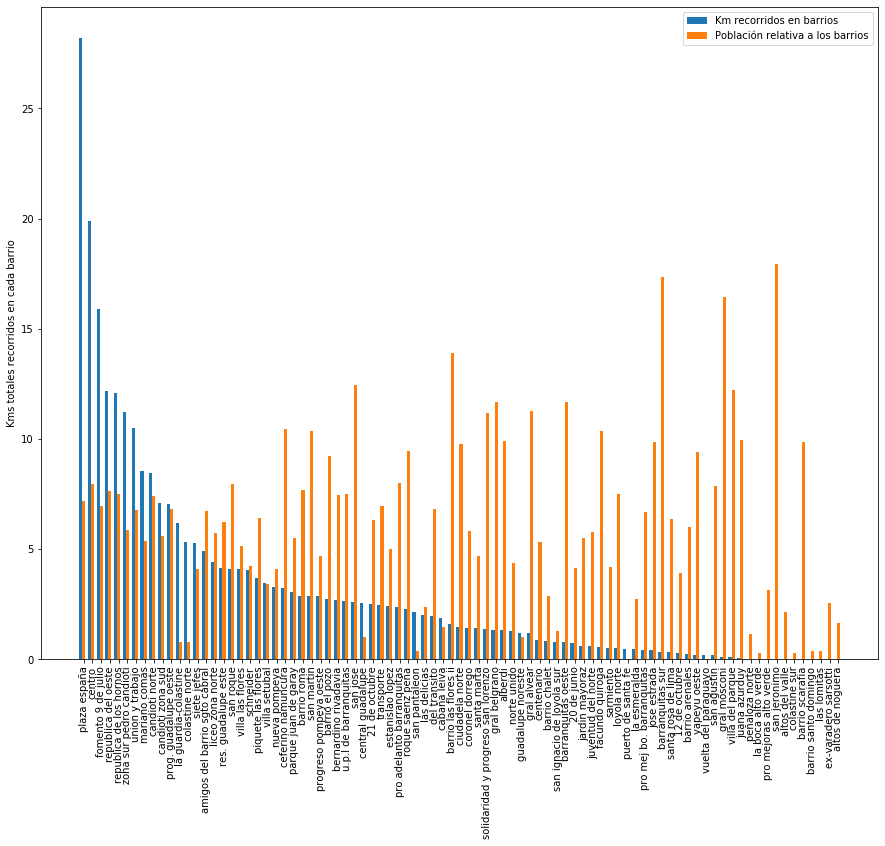

In [106]:
plt.figure(figsize=(15,12))
ind = np.arange(0, len(barrios_poblacion)*2, 2)
width = 0.7

plt.bar(ind,barrios_poblacion.sort_values('km recorridos', ascending=False)['km recorridos'], width)
plt.bar(ind + width, barrios_poblacion.sort_values('km recorridos', ascending=False)['Densidad poblacional m2'], width)
#plt.bar(ind + width + width, barrios_poblacion.sort_values('km recorridos', ascending=False)['Poblacion'], width, color='r')
plt.xticks(rotation=90)
plt.xticks(ind + width*2/ 2, barrios_poblacion.sort_values('km recorridos', ascending=False)['Barrio'])
plt.ylabel('Kms totales recorridos en cada barrio')
plt.legend(['Km recorridos en barrios', 'Población relativa a los barrios'])
plt.show()
#plt.savefig('recorridos y densidad.png', dpi=300, bbox_inches='tight')

In [109]:
barrios_poblacion['P%'] = (barrios_poblacion['Poblacion']/barrios_poblacion['Poblacion'].sum())
barrios_poblacion['KM%'] = (barrios_poblacion['km recorridos']/barrios_poblacion['km recorridos'].sum())
barrios_poblacion['Dp%'] = (barrios_poblacion['Densidad poblacional m2']/barrios_poblacion['Densidad poblacional m2'].sum())*100

##### Estos números muestran lo que se observa en los mapas: la mayor presencia de colectivos en los barrios de la zona céntrica de la ciudad. Por ejemplo, en el Barrio Centro, todos los colectivos hacen de 100m a 1km, en el trayecto de ida, apenas dos (1 y 13 a la vuelta) pasan por este barrio; y en el caso de Plaza España, a excepción del 9 y el 16 de ida, transitan al menos 1 km, y a la vuelta, a excepción del 1 y el 3, transitan también al menos 1km. Con respecto a la tabla de arriba, hemos dejado al barrio Mariano Comas, ya que a partir de este barrio con una extensión de recorridos de colectivos en 8.5 km, comienzan a descender los km transitados.
##### También observando los mapas más arriba, encontramos que los recorridos merman a medida que se alejan de esta zona, se abren y las líneas se separan como siguiendo el dibujo en cuña que tiene la ciudad. Nos preguntamos, según la población relativa, que es esa cantidad de población que habita un territorio determinado, ¿cómo los colectivos intervienen en esos barrios con su distancia recorrida? El resultado es el siguiente gráfico de barras, donde la correlación entre los km y la densidad poblacional es de 0.038:


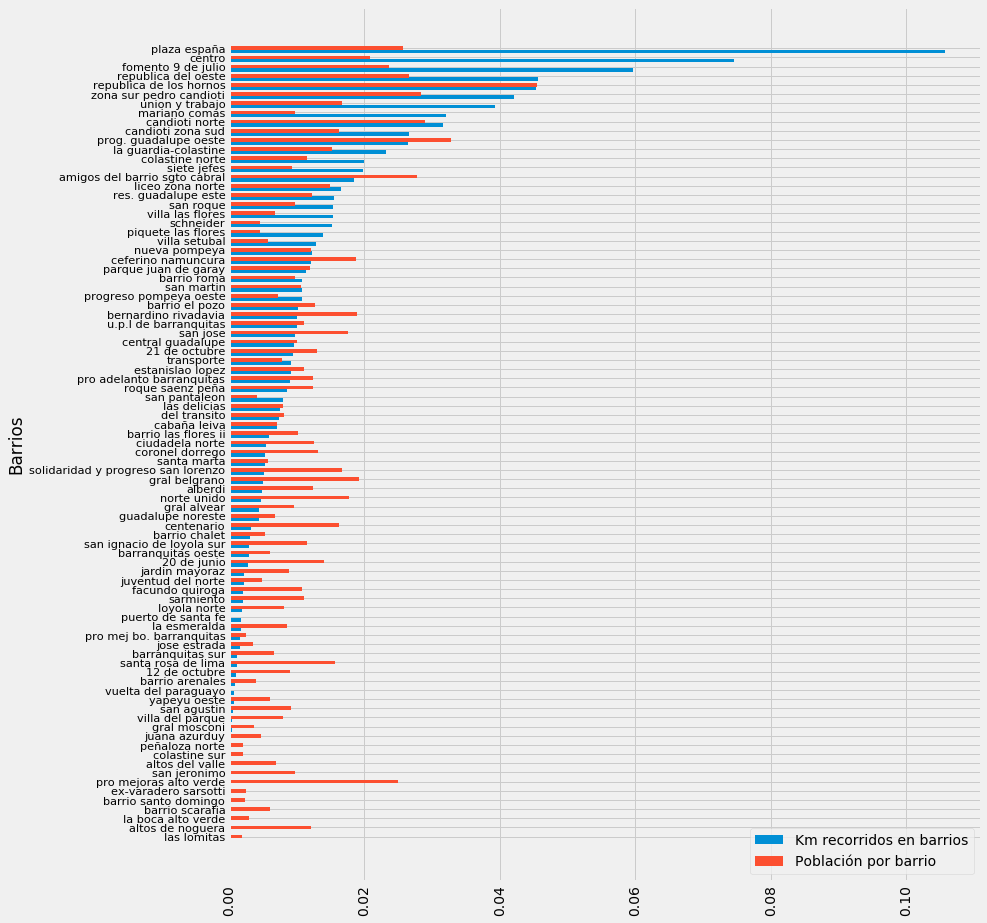

In [110]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(12,15))
ind = np.arange(0, len(barrios_poblacion)*2, 2)
width = 0.7

plt.barh(ind,barrios_poblacion.sort_values('km recorridos', ascending=True)['KM%'])
#plt.bar(ind + width, barrios_poblacion.sort_values('km recorridos', ascending=False)['Dp%'], width)
plt.barh(ind + width, barrios_poblacion.sort_values('km recorridos', ascending=True)['P%'])
plt.xticks(rotation=90)
plt.yticks(ind + width*2/ 2, barrios_poblacion.sort_values('km recorridos', ascending=True)['Barrio'], fontsize=11.3)
plt.ylabel('Barrios')
plt.legend(['Km recorridos en barrios', 'Población por barrio'])
plt.show()

##### Es decir que el diagramado de los recorridos no está pensado para ingresar en las zonas más densamente pobladas de la ciudad, permitiendo generar accesibilidad de sus habitantes al resto del territorio. También demostramos así la sobreexplotación de las calles del centro de la ciudad. Los colectivos sólo siguen en mayor medida el dibujo de las avenidas principales y las calles céntricas, y al seguir las líneas este dibujo, es lógico que se produzcan embotellamientos, caída drástica de la frecuencia y zonas y barrios desconectados de la ciudad.

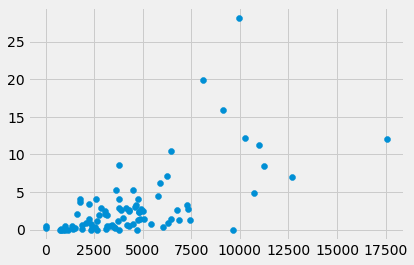

In [111]:
plt.scatter(barrios_poblacion['Poblacion'], barrios_poblacion['km recorridos'])

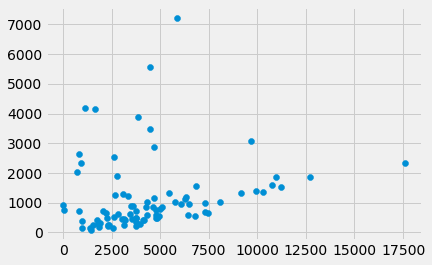

In [112]:
plt.scatter(barrios_poblacion['Poblacion'], barrios_poblacion['Superficie barrio'])

#### Seleccionar un barrio

In [ ]:
bar = list(itertools.chain.from_iterable(itertools.chain.from_iterable(stafe_barrios_vectores['features'][12]['geometry']['coordinates'])))
bb = []
for i in range(len(bar)):
    b = bar[i][::-1]
    bb.append(b)

In [ ]:
mapa2 = folium.Map(location=[-31.626214, -60.707501], tiles='cartodbpositron', zoom_start=12)
barrio_lim =folium.PolyLine(locations=bb, color="red", weight=1, opacity=1)
mapa2.add_child(barrio_lim)
b_linea =folium.PolyLine(locations=l4, color="red", weight=1, opacity=1)
mapa2.add_child(b_linea)

### Intersecciones entre líneas de colectivos y barrios (polígonos y líneas)

In [ ]:
import shapely.geometry
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
from shapely.geometry.polygon import LinearRing

In [ ]:
mapa2 = folium.Map(location=[-31.626214, -60.707501], tiles='cartodbpositron', zoom_start=12)
barrio_lim =folium.PolyLine(locations=bb, color="red", weight=1, opacity=1)
mapa2.add_child(barrio_lim)
b_linea =folium.PolyLine(locations=l4v, color="red", weight=1, opacity=1)
mapa2.add_child(b_linea)
puntos = folium.Marker([-31.577673, -60.74249])
mapa2.add_child(puntos)

## Creación de GeoJson a partir de las coordenadas de los recorridos de los colectivos

In [ ]:
from geojson import Point, Feature, FeatureCollection, dump

In [ ]:
features = []
features.append(Feature(geometry=Point((l1)), properties={'id' : 'ida 1'}))
features.append(Feature(geometry=Point((l2)), properties={'id' : 'ida 2'}))
features.append(Feature(geometry=Point((l3)), properties={'id' : 'ida 3'}))
features.append(Feature(geometry=Point((l4)), properties={'id' : 'ida 4'}))
features.append(Feature(geometry=Point((l5)), properties={'id' : 'ida 5'}))
features.append(Feature(geometry=Point((l8)), properties={'id' : 'ida 8'}))
features.append(Feature(geometry=Point((l9)), properties={'id' : 'ida 9'}))
features.append(Feature(geometry=Point((l10)), properties={'id' : 'ida 10'}))
features.append(Feature(geometry=Point((l11)), properties={'id' : 'ida 11'}))
features.append(Feature(geometry=Point((l13)), properties={'id' : 'ida 13'}))
features.append(Feature(geometry=Point((l14)), properties={'id' : 'ida 14'}))
features.append(Feature(geometry=Point((l15)), properties={'id' : 'ida 15'}))
features.append(Feature(geometry=Point((l16)), properties={'id' : 'ida 16'}))
features.append(Feature(geometry=Point((l18)), properties={'id' : 'ida 18'}))
features.append(Feature(geometry=Point((l1v)), properties={'id' : 'vuelta 1'}))
features.append(Feature(geometry=Point((l2v)), properties={'id' : 'vuelta 2'}))
features.append(Feature(geometry=Point((l3v)), properties={'id' : 'vuelta 3'}))
features.append(Feature(geometry=Point((l4v)), properties={'id' : 'vuelta 4'}))
features.append(Feature(geometry=Point((l5v)), properties={'id' : 'vuelta 5'}))
features.append(Feature(geometry=Point((l8v)), properties={'id' : 'vuelta 8'}))
features.append(Feature(geometry=Point((l9v)), properties={'id' : 'vuelta 9'}))
features.append(Feature(geometry=Point((l10v)), properties={'id' : 'vuelta 10'}))
features.append(Feature(geometry=Point((l11v)), properties={'id' : 'vuelta 11'}))
features.append(Feature(geometry=Point((l13v)), properties={'id' : 'vuelta  13'}))
features.append(Feature(geometry=Point((l14v)), properties={'id' : 'vuelta  14'}))
features.append(Feature(geometry=Point((l15v)), properties={'id' : 'vuelta 15'}))
features.append(Feature(geometry=Point((l16v)), properties={'id' : 'vuelta 16'}))
features.append(Feature(geometry=Point((l18v)), properties={'id' : 'vuelta 18'}))

feature_collection = FeatureCollection(features)

#SAVE el geojson generado
#with open('recorrido_lineas_TUP_stafe.geojson', 'w') as rl:
#    dump(feature_collection, rl)

In [ ]:
lineas_recorrido_gj = r'C:\Users\Mauricio\Documents\jupyter\subsidios\recorrido_lineas_TUP_stafe.geojson'
lr_geojson = json.load(open(lineas_recorrido_gj))

In [ ]:
#Construir una tabla matriz donde cada línea es un atributo del barrio
barrio_nomb = []
nombre_linea = []
km = []
for i in range(len(stafe_barrios_vectores['features'])):
    #nombre del barrio
    nb = stafe_barrios_vectores['features'][i]['properties']['id']
    barrio_nomb.append(nb)
    #polígono del barrio
    barrio_polygon = list(itertools.chain.from_iterable(itertools.chain.from_iterable(stafe_barrios_vectores['features'][i]['geometry']['coordinates'])))
    bb_p = []
    for bp in range(len(barrio_polygon)):
        b = barrio_polygon[bp][::-1]
        bb_p.append(b)
    
    #límites externos del polígono
    p_b= Polygon(bb_p)
    p_b_exc=LinearRing(p_b.exterior.coords)
    
    #línea de colectivo que interseca al polígono del barrio
    for l_intersects in range(len(lr_geojson['features'])):
        #nombre de la línea
        nl = lr_geojson['features'][l_intersects]['properties']['id']
        
        l_escrut = shapely.geometry.LineString(lr_geojson['features'][l_intersects]['geometry']['coordinates'])
        
        if l_escrut.intersects(p_b_exc):
            try:
                for inter in range(len(p_b_exc.intersection(l_escrut))):
                    km_intersects = (p_b_exc.intersection(l_escrut)[inter].distance(p_b_exc.intersection(l_escrut)[inter+1]))*100
                    inter = inter+2
            except:
                pass
        else:
            km_intersects = 0
        km.append(round(km_intersects, 4))
        nombre_linea.append(nl)

In [ ]:
matrix = np.array(km).reshape(len(barrio_nomb), len(lr_geojson['features']))
df_matrix = pd.DataFrame(matrix)
df_matrix.columns= nombre_linea[:28]
df_matrix['Barrio'] = barrio_nomb
col = df_matrix.columns.tolist()
col = col[-1:] + col[:-1]
df_matrix = df_matrix[col]
df_matrix.reset_index(inplace=True, drop=True)

In [ ]:
#df_matrix.to_csv('km recorridos por colectivo por barrio.csv', sep=';', encoding='latin1')

In [ ]:
df_matrixT = df_matrix.T
df_matrixT.drop('Barrio', axis=0, inplace=True)

In [ ]:
#Cuáles colectivos por barrio en ida y vuelta
cole_x_barrio = []
for i in range(len(df_matrixT.columns)):
    lista_cole=df_matrixT[df_matrixT.iloc[:, i]>0].iloc[:,i].index
    lc_l=[]
    for a in range(len(lista_cole)):
        lc=lista_cole[a]
        lc_l.append(lc)
    
    cole_x_barrio.append(lc_l)

#Dataframe con esta información generada
colectivo_barrio = pd.DataFrame({'Barrio' : barrio_nomb,
                                 'Colectivo por barrio' : cole_x_barrio})

In [ ]:
#colectivo_barrio.to_csv('colectivo por barrio.csv', sep=';', encoding='latin1')

In [ ]:
#KM totales por línea de colectivo por barrio
km_totales = []
for i in range(len(df_matrixT.columns)):
    suma=df_matrixT.iloc[0:, i].sum()
    km_totales.append(round(suma, 2))

In [ ]:
#barrios_poblacion['km recorridos'] = km_totales

## Primeros pasos para construir las tablas

In [ ]:
#Diferencia entre dos listas
#def diff(list1, list2):
#    return list(set(list1).symmetric_difference(set(list2)))

In [ ]:
#Barrios para cruce de nombres entre la tabla del ipec y el geojson de la ciudad de santa fe
barrios_lista = ['LA GUARDIA-COLASTINE', 
                 'COLASTINE SUR', 
                 'COLASTINE NORTE', 
                 'Mariano Comas', 
                 'Candioti Zona Sud', 
                 'Plaza España', 
                 'Republica del Oeste', 
                 'Centro', 
                 'Zona Sur Pedro Candioti',
                 'Roque Saenz Peña', 
                 'Barrio Roma',
                 'Centenario',
                 'San Jeronimo',
                 'Barrio Chalet',
                 'Barrio Arenales',
                 'Solidaridad y Progreso San Lorenzo',
                 '12 de Octubre',
                 'Santa Rosa de Lima',
                 'Jose Estrada',
                 'Parque Juan de Garay',
                 'Villa del Parque',
                 'Pro Adelanto Barranquitas',
                 'U.P.L de Barranquitas',
                 'Puerto de Santa Fe',
                 'PRO MEJORAS ALTO VERDE',
                 'Vuelta del Paraguayo',
                 'Fomento 9 de Julio',
                 'Ex-Varadero Sarsotti',
                 'Republica de los Hornos',
                 'Jardin Mayoraz',
                 'Sarmiento',
                 'Las Lomitas',
                 'Barrio Santo Domingo',
                 '20 de Junio',
                 'San Ignacio de Loyola Sur',
                 'Del Transito',
                 'Juana Azurduy',
                 'Barrio Scarafia',
                 'Juventud del Norte',
                 'Estanislao Lopez',
                 'Loyola Norte',
                 'San Agustin',
                 'Santa Marta',
                 'Ceferino Namuncura',
                 'Yapeyu Oeste',
                 'Norte Unido',
                 'Cabaña Leiva',
                 'Bernardino Rivadavia',
                 'Liceo Zona Norte',
                 '21 de Octubre',
                 'BARRIO LAS FLORES II',
                 'Villa Las Flores',
                 'San Martin',
                 'San Jose',
                 'Progreso Pompeya Oeste',
                 'Altos de Noguera',
                 'Peñaloza Norte',
                 'Las Delicias',
                 'Nueva Pompeya',
                 'Transporte',
                 'Gral Belgrano',
                 'Facundo Quiroga',
                 'Piquete Las Flores',
                 'Altos del Valle',
                 'La Esmeralda',
                 'Prog. Guadalupe Oeste',
                 'Coronel Dorrego',
                 'Candioti Norte',
                 'Gral Alvear',
                 'San Roque',
                 'Amigos del Barrio Sgto Cabral',
                 'Union y Trabajo',
                 'Alberdi',
                 'Res. Guadalupe Este',
                 'Central Guadalupe',
                 'Guadalupe Noreste',
                 'Villa Setubal',
                 'Siete Jefes',
                 'Barranquitas Sur',
                 'Barranquitas Oeste',
                 'Pro Mej Bo. Barranquitas',
                 'Schneider',
                 'Ciudadela Norte',
                 'San Pantaleon',
                 'BARRIO EL POZO',
                 'La Boca Alto Verde',
                 'Gral Mosconi']

In [ ]:
#Asignación de valores nuevos a GeoJson: Nombre de barrios a polígonos del GeoJson
for i in range(len(stafe_barrios_poligonos['features'])):
    stafe_barrios_poligonos['features'][i]['properties']['id']=barrios_lista[i].upper()

In [ ]:
#Construcción de la tabla con barrios ordenados según GeoJson de Ciudad de Santa Fe
#y asignación de población según el índice del orden de cada uno de los barrios en la lista mencionada

pob_barrio = []
nom_barrio = []
try:
    for i in range(len(stafe_barrios_vectores['features'])):
        char2=stafe_barrios_vectores['features'][i]['properties']['id'].lower()
        if char2 == 'puerto de santa fe':
            pb = 0
            pob_barrio.append(pb)
            nom_barrio.append(char2)
            
        elif char2 != 'puerto de santa fe':
            for a in range(len(poblacion_por_barrios)):
                char2=stafe_barrios_vectores['features'][i]['properties']['id'].lower()
                char1=poblacion_por_barrios['Barrio'][a].lower()
                if char1 == char2:
                    pb = poblacion_por_barrios['Total Poblacion'][a]
                    pob_barrio.append(pb)
                    nom_barrio.append(char1)
except (KeyError):
    pass

In [ ]:
#Primeros pasos para construir el GeoJson: comparación de listas de nombres de barrios
#entre el GeoJson y la tabla del IPEC
#barrios1 = []
#for i in range(len(stafe_barrios_vectores_pob['features'])):
#    barrios1.append(stafe_barrios_vectores_pob['features'][i]['properties']['id'])
#barrios2 = []
#for i in range(len(poblacion_por_barrios)):
#    barrios2.append(poblacion_por_barrios['Barrio'][i])

In [ ]:
#barrios_poblacion = pd.DataFrame({'Barrio' : nom_barrio,
#                                  'Poblacion' : pob_barrio})

In [ ]:
#Tabla ordenada: asignación de población a cada barrio DENTRO del GeoJson
for i in range(len(stafe_barrios_vectores['features'])):
    stafe_barrios_vectores['features'][i]['properties']['pob']=int(barrios_poblacion['Poblacion'][i])

In [ ]:
#Tabla ordenada: asignación de densidad poblacional a cada barrio DENTRO del GeoJson
for i in range(len(stafe_barrios_vectores['features'])):
    stafe_barrios_vectores['features'][i]['properties']['dens']=float(barrios_poblacion['Densidad poblacional m2'][i])

In [ ]:
#función para comparación de listas
#def diff(list1, list2):
#    c = set(list1).union(set(list2))  # or c = set(list1) | set(list2)
#    d = set(list1).intersection(set(list2))  # or d = set(list1) & set(list2)
#    return list(c - d)

In [ ]:
mapa_loop = folium.Map(location=[-31.626214, -60.707501], tiles='cartodbpositron', zoom_start=12)

In [ ]:
for c in range(0,9):
    folium.GeoJson(stafe_barrios_vectores, style_function=piste_style_function).add_to(mapa_loop)

for i in range(len(lr_geojson['features'])):
    a = folium.PolyLine(locations=[lr_geojson['features'][i]['geometry']['coordinates']], color="white", weight=5, opacity=0.2)
    a.add_to(mapa_loop)
mapa_loop

In [ ]:
'''
folium.GeoJson(stafe_barrios_vectores, style_function=piste_style_function).add_to(mapa)
folium.GeoJson(stafe_barrios_vectores, style_function=piste_style_function).add_to(mapa)
folium.GeoJson(stafe_barrios_vectores, style_function=piste_style_function).add_to(mapa)
folium.GeoJson(stafe_barrios_vectores, style_function=piste_style_function).add_to(mapa)
folium.GeoJson(stafe_barrios_vectores, style_function=piste_style_function).add_to(mapa)
folium.GeoJson(stafe_barrios_vectores, style_function=piste_style_function).add_to(mapa)
folium.GeoJson(stafe_barrios_vectores, style_function=piste_style_function).add_to(mapa)
folium.GeoJson(stafe_barrios_vectores, style_function=piste_style_function).add_to(mapa)
folium.GeoJson(stafe_barrios_vectores, style_function=piste_style_function).add_to(mapa)
folium.GeoJson(stafe_barrios_vectores, style_function=piste_style_function).add_to(mapa)
folium.GeoJson(stafe_barrios_vectores, style_function=piste_style_function).add_to(mapa)
folium.GeoJson(stafe_barrios_vectores, style_function=piste_style_function).add_to(mapa)
#folium.GeoJson(stafe_barrios_vectores).add_to(mapa)
l_l4 = folium.PolyLine(locations=[l4], color="white", weight=5, opacity=0.2)
mapa.add_child(l_l4)
l_10 = folium.PolyLine(locations=[l10], color="white", weight=5, opacity=0.2)
mapa.add_child(l_10)
l_l11 = folium.PolyLine(locations=[l11], color="white", weight=5, opacity=0.2)
mapa.add_child(l_l11)
l_l8 = folium.PolyLine(locations=[l8], color="white", weight=5, opacity=0.2)
mapa.add_child(l_l8)
l_l14 = folium.PolyLine(locations=[l14], color="white", weight=5, opacity=0.2)
mapa.add_child(l_l14)
l_l18 = folium.PolyLine(locations=[l18], color="white", weight=5, opacity=0.2)
mapa.add_child(l_l18)
l_l16 = folium.PolyLine(locations=[l16], color="white", weight=5, opacity=0.2)
mapa.add_child(l_l16)
l_l5 = folium.PolyLine(locations=[l5], color="white", weight=5, opacity=0.2)
mapa.add_child(l_l5)
l_l13 = folium.PolyLine(locations=[l13], color="white", weight=5, opacity=0.2)
mapa.add_child(l_l13)
l_rb = folium.PolyLine(locations=[lrondaB], color="white", weight=5, opacity=0.2)
mapa.add_child(l_rb)
l_recreo = folium.PolyLine(locations=[recreo], color="white", weight=3, opacity=0.2)
mapa.add_child(l_recreo)

l_l1 = folium.PolyLine(locations=[l1], color="white", weight=5, opacity=0.2)
mapa.add_child(l_l1)
l_l3 = folium.PolyLine(locations=[l3], color="white", weight=5, opacity=0.2)
mapa.add_child(l_l3)
l_l15 = folium.PolyLine(locations=[l15], color="white", weight=5, opacity=0.2)
mapa.add_child(l_l15)
l_l2= folium.PolyLine(locations=[l2], color="white", weight=5, opacity=0.2)
mapa.add_child(l_l2)
l_l2col= folium.PolyLine(locations=[l2col], color="white", weight=5, opacity=0.2)
mapa.add_child(l_l2col)
l_l9= folium.PolyLine(locations=[l9], color="white", weight=5, opacity=0.2)
mapa.add_child(l_l9)

#car_ex_riv =folium.PolyLine(locations=[carril_riv], color="orange", weight=7, opacity=1)
#mapa.add_child(car_ex_riv)

l_l4_v =folium.PolyLine(locations=[l4v], color="white", weight=5, opacity=0.2)
mapa.add_child(l_l4_v)
l_l10_v =folium.PolyLine(locations=[l10v], color="white", weight=5, opacity=0.2)
mapa.add_child(l_l10_v)
l_l11_v =folium.PolyLine(locations=[l11v], color="white", weight=5, opacity=0.2)
mapa.add_child(l_l11_v)
l_l8_v =folium.PolyLine(locations=[l8v], color="white", weight=5, opacity=0.2)
mapa.add_child(l_l8_v)
l_l14_v =folium.PolyLine(locations=[l14v], color="white", weight=5, opacity=0.2)
mapa.add_child(l_l14_v)
l_l16_v =folium.PolyLine(locations=[l16v], color="white", weight=5, opacity=0.2)
mapa.add_child(l_l16_v)
l_l18_v =folium.PolyLine(locations=[l18v], color="white", weight=5, opacity=0.2)
mapa.add_child(l_l18_v)
l_l5_v =folium.PolyLine(locations=[l5v], color="white", weight=5, opacity=0.2)
mapa.add_child(l_l5_v)
l_l13_v =folium.PolyLine(locations=[l13v], color="white", weight=5, opacity=0.2)
mapa.add_child(l_l13_v)
l_l13_v =folium.PolyLine(locations=[l13v], color="white", weight=5, opacity=0.2)
mapa.add_child(l_l13_v)
l_lrecreo_v =folium.PolyLine(locations=[recreov], color="white", weight=5, opacity=0.2)
mapa.add_child(l_lrecreo_v)
l_lrondab_v =folium.PolyLine(locations=[rondabv], color="white", weight=5, opacity=0.2)
mapa.add_child(l_lrondab_v)
l_l2_v =folium.PolyLine(locations=[l2v], color="white", weight=5, opacity=0.2)
mapa.add_child(l_l2_v)
l_l2col_v =folium.PolyLine(locations=[l2colv], color="white", weight=5, opacity=0.2)
mapa.add_child(l_l2col_v)
l_l3_v =folium.PolyLine(locations=[l3v], color="white", weight=5, opacity=0.2)
mapa.add_child(l_l3_v)
l_l9_v =folium.PolyLine(locations=[l9v], color="white", weight=5, opacity=0.2)
mapa.add_child(l_l9_v)
l_l15_v =folium.PolyLine(locations=[l15v], color="white", weight=5, opacity=0.2)
mapa.add_child(l_l15_v)

colormap = branca.colormap.LinearColormap(pob_color)
colormap = colormap.to_step(index=[0, 2512, 5024, 7536, 10049, 12561, 15073, 17585])
colormap.caption = 'Población por barrio'
colormap.add_to(mapa)
mapa
'''

In [ ]:
'''
mapa_dens = folium.Map(location=[-31.626214, -60.707501], tiles='cartodbpositron', zoom_start=12)
folium.GeoJson(stafe_barrios_vectores, style_function=piste_style_function_density).add_to(mapa_dens)
folium.GeoJson(stafe_barrios_vectores, style_function=piste_style_function_density).add_to(mapa_dens)
folium.GeoJson(stafe_barrios_vectores, style_function=piste_style_function_density).add_to(mapa_dens)
folium.GeoJson(stafe_barrios_vectores, style_function=piste_style_function_density).add_to(mapa_dens)
folium.GeoJson(stafe_barrios_vectores, style_function=piste_style_function_density).add_to(mapa_dens)
folium.GeoJson(stafe_barrios_vectores, style_function=piste_style_function_density).add_to(mapa_dens)
folium.GeoJson(stafe_barrios_vectores, style_function=piste_style_function_density).add_to(mapa_dens)
folium.GeoJson(stafe_barrios_vectores, style_function=piste_style_function_density).add_to(mapa_dens)
folium.GeoJson(stafe_barrios_vectores, style_function=piste_style_function_density).add_to(mapa_dens)
folium.GeoJson(stafe_barrios_vectores, style_function=piste_style_function_density).add_to(mapa_dens)
folium.GeoJson(stafe_barrios_vectores, style_function=piste_style_function_density).add_to(mapa_dens)
folium.GeoJson(stafe_barrios_vectores, style_function=piste_style_function_density).add_to(mapa_dens)
#folium.GeoJson(stafe_barrios_vectores).add_to(mapa)
l_l4 = folium.PolyLine(locations=[l4], color="white", weight=5, opacity=0.2)
mapa_dens.add_child(l_l4)
l_10 = folium.PolyLine(locations=[l10], color="white", weight=5, opacity=0.2)
mapa_dens.add_child(l_10)
l_l11 = folium.PolyLine(locations=[l11], color="white", weight=5, opacity=0.2)
mapa_dens.add_child(l_l11)
l_l8 = folium.PolyLine(locations=[l8], color="white", weight=5, opacity=0.2)
mapa_dens.add_child(l_l8)
l_l14 = folium.PolyLine(locations=[l14], color="white", weight=5, opacity=0.2)
mapa_dens.add_child(l_l14)
l_l18 = folium.PolyLine(locations=[l18], color="white", weight=5, opacity=0.2)
mapa_dens.add_child(l_l18)
l_l16 = folium.PolyLine(locations=[l16], color="white", weight=5, opacity=0.2)
mapa_dens.add_child(l_l16)
l_l5 = folium.PolyLine(locations=[l5], color="white", weight=5, opacity=0.2)
mapa_dens.add_child(l_l5)
l_l13 = folium.PolyLine(locations=[l13], color="white", weight=5, opacity=0.2)
mapa_dens.add_child(l_l13)
l_rb = folium.PolyLine(locations=[lrondaB], color="white", weight=5, opacity=0.2)
mapa_dens.add_child(l_rb)
l_recreo = folium.PolyLine(locations=[recreo], color="white", weight=3, opacity=0.2)
mapa_dens.add_child(l_recreo)

l_l1 = folium.PolyLine(locations=[l1], color="white", weight=5, opacity=0.2)
mapa_dens.add_child(l_l1)
l_l3 = folium.PolyLine(locations=[l3], color="white", weight=5, opacity=0.2)
mapa_dens.add_child(l_l3)
l_l15 = folium.PolyLine(locations=[l15], color="white", weight=5, opacity=0.2)
mapa_dens.add_child(l_l15)
l_l2= folium.PolyLine(locations=[l2], color="white", weight=5, opacity=0.2)
mapa_dens.add_child(l_l2)
l_l2col= folium.PolyLine(locations=[l2col], color="white", weight=5, opacity=0.2)
mapa_dens.add_child(l_l2col)
l_l9= folium.PolyLine(locations=[l9], color="white", weight=5, opacity=0.2)
mapa_dens.add_child(l_l9)

#car_ex_riv =folium.PolyLine(locations=[carril_riv], color="orange", weight=7, opacity=1)
#mapa.add_child(car_ex_riv)

l_l4_v =folium.PolyLine(locations=[l4v], color="white", weight=5, opacity=0.2)
mapa_dens.add_child(l_l4_v)
l_l10_v =folium.PolyLine(locations=[l10v], color="white", weight=5, opacity=0.2)
mapa_dens.add_child(l_l10_v)
l_l11_v =folium.PolyLine(locations=[l11v], color="white", weight=5, opacity=0.2)
mapa_dens.add_child(l_l11_v)
l_l8_v =folium.PolyLine(locations=[l8v], color="white", weight=5, opacity=0.2)
mapa_dens.add_child(l_l8_v)
l_l14_v =folium.PolyLine(locations=[l14v], color="white", weight=5, opacity=0.2)
mapa_dens.add_child(l_l14_v)
l_l16_v =folium.PolyLine(locations=[l16v], color="white", weight=5, opacity=0.2)
mapa_dens.add_child(l_l16_v)
l_l18_v =folium.PolyLine(locations=[l18v], color="white", weight=5, opacity=0.2)
mapa_dens.add_child(l_l18_v)
l_l5_v =folium.PolyLine(locations=[l5v], color="white", weight=5, opacity=0.2)
mapa_dens.add_child(l_l5_v)
l_l13_v =folium.PolyLine(locations=[l13v], color="white", weight=5, opacity=0.2)
mapa_dens.add_child(l_l13_v)
l_l13_v =folium.PolyLine(locations=[l13v], color="white", weight=5, opacity=0.2)
mapa_dens.add_child(l_l13_v)
l_lrecreo_v =folium.PolyLine(locations=[recreov], color="white", weight=5, opacity=0.2)
mapa_dens.add_child(l_lrecreo_v)
l_lrondab_v =folium.PolyLine(locations=[rondabv], color="white", weight=5, opacity=0.2)
mapa_dens.add_child(l_lrondab_v)
l_l2_v =folium.PolyLine(locations=[l2v], color="white", weight=5, opacity=0.2)
mapa_dens.add_child(l_l2_v)
l_l2col_v =folium.PolyLine(locations=[l2colv], color="white", weight=5, opacity=0.2)
mapa_dens.add_child(l_l2col_v)
l_l3_v =folium.PolyLine(locations=[l3v], color="white", weight=5, opacity=0.2)
mapa_dens.add_child(l_l3_v)
l_l9_v =folium.PolyLine(locations=[l9v], color="white", weight=5, opacity=0.2)
mapa_dens.add_child(l_l9_v)
l_l15_v =folium.PolyLine(locations=[l15v], color="white", weight=5, opacity=0.2)
mapa_dens.add_child(l_l15_v)
colormap = branca.colormap.LinearColormap(dens_color)
colormap = colormap.to_step(index=[0, 4, 8, 13, 17, 21, 25, 29])
colormap.caption = 'Densidad poblacional por barrio (hab/m2)'
colormap.add_to(mapa_dens)

mapa_dens
'''

In [ ]:
#points = [[-31.637566, -60.694236], [-31.633179, -60.714835]]
carril_riv = [[-31.648293, -60.705829], [-31.648203, -60.705816], [-31.647649, -60.705352], [-31.647326, -60.704993], [-31.647195, -60.704919], [-31.646185, -60.704234], [-31.644927, -60.703806], [-31.636138, -60.701120]]
l4 = [[-31.599615, -60.665478], [-31.600268, -60.665582], [-31.600067, -60.666643], [-31.603607, -60.667631], [-31.602251, -60.674588], [-31.604900, -60.675429], [-31.608278, -60.677227], [-31.606997, -60.684288], [-31.609445, -60.685040], [-31.608278, -60.690332], [-31.606043, -60.689698], [-31.605461, -60.692714], [-31.611217, -60.694670], [-31.616339, -60.697810], [-31.629271, -60.700754], [-31.633079, -60.701776], [-31.632617, -60.703902], [-31.649995, -60.708961], [-31.649635, -60.710150], [-31.649236, -60.712714], [-31.648446, -60.716591], [-31.663115, -60.720892], [-31.662653, -60.723517], [-31.665459, -60.726665],[-31.666048, -60.726007]]
l10 =[[-31.569528, -60.689798], [-31.574449, -60.690519], [-31.580069, -60.689406], [-31.590568, -60.692196], [-31.595357, -60.691934], [-31.597179, -60.683710], [-31.600796, -60.684738], [-31.602178, -60.678367], [-31.603086, -60.678664], [-31.600233, -60.691915], [-31.602654, -60.692064], [-31.606767, -60.693070], [-31.611420, -60.694751], [-31.616575, -60.697841], [-31.633102, -60.701722], [-31.632620, -60.703886], [-31.657796, -60.711249], [-31.657637, -60.712531]]
l11 = [[-31.566679, -60.704887], [-31.566217, -60.704750], [-31.567544, -60.699166], [-31.568825, -60.699586], [-31.566778, -60.708084], [-31.568043, -60.708494], [-31.567412, -60.711183], [-31.565858, -60.710714], [-31.565600, -60.711902], [-31.568220, -60.712684], [-31.568513, -60.711506], [-31.569295, -60.711746], [-31.569563, -60.710356], [-31.573263, -60.711601], [-31.573136, -60.712210], [-31.574548, -60.712723], [-31.574473, -60.713121], [-31.574637, -60.713235], [-31.575646, -60.713051], [-31.575571, -60.714213], [-31.582429, -60.714769], [-31.583045, -60.711355], [-31.588110, -60.711777], [-31.588398, -60.710457], [-31.586746, -60.709949], [-31.589260, -60.698121], [-31.602801, -60.702273], [-31.604279, -60.695550], [-31.606108, -60.696119], [-31.606765, -60.693096], [-31.606767, -60.693070], [-31.611420, -60.694751], [-31.616575, -60.697841], [-31.633102, -60.701722], [-31.632620, -60.703886], [-31.657796, -60.711249]]
l8 = [[-31.595713, -60.675967], [-31.596343, -60.673058], [-31.604961, -60.675393], [-31.610850, -60.678582], [-31.612480, -60.679922], [-31.610807, -60.687692], [-31.619760, -60.690346], [-31.620520, -60.686072], [-31.630968, -60.693588], [-31.638202, -60.695804], [-31.637143, -60.700796], [-31.637313, -60.701148], [-31.636491, -60.705030], [-31.662925, -60.712785], [-31.662592, -60.714651], [-31.662793, -60.715349], [-31.661953, -60.720627], [-31.663090, -60.720868]]
l14 = [[-31.599615, -60.665478], [-31.600268, -60.665582], [-31.600067, -60.666643], [-31.601785, -60.667135], [-31.601370, -60.669255], [-31.614027, -60.672722], [-31.612463, -60.679921], [-31.620519, -60.686119], [-31.630968, -60.693588], [-31.631731, -60.693812], [-31.630809, -60.698114], [-31.638473, -60.700380], [-31.638622, -60.700562], [-31.638583, -60.700744], [-31.644026, -60.702426], [-31.643107, -60.707043], [-31.649941, -60.709007], [-31.649635, -60.710150], [-31.649236, -60.712714], [-31.647406, -60.721913], [-31.644344, -60.721102], [-31.642956, -60.726300], [-31.637855, -60.724745], [-31.634246, -60.724052], [-31.632025, -60.720337], [-31.633148, -60.714972], [-31.653980, -60.720996], [-31.653741, -60.722481], [-31.654858, -60.722797]]
l16 = [[-31.591039, -60.694398], [-31.590175, -60.694140], [-31.589162, -60.698057], [-31.599165, -60.701170], [-31.601417, -60.690882] , [-31.599610, -60.690357] , [-31.603044, -60.674801] , [-31.603156, -60.674736] , [-31.604906, -60.665943], [-31.605225, -60.665819], [-31.610350, -60.667267], [-31.612079, -60.668313], [-31.618995, -60.676758], [-31.621854, -60.678336], [-31.624745, -60.679130], [-31.626222, -60.679179], [-31.625997, -60.680564], [-31.639492, -60.684682], [-31.632993, -60.714954], [-31.645001, -60.718425], [-31.644682, -60.719736], [-31.645871, -60.720059], [-31.648813, -60.708687], [-31.662918, -60.712804], [-31.662586, -60.714647], [-31.662789, -60.715270], [-31.662546, -60.716903], [-31.656159, -60.714925], [-31.655114, -60.721040]]
l18 = [[-31.574578, -60.719598], [-31.574689, -60.719118], [-31.577485, -60.719434], [-31.577545, -60.719375], [-31.581553, -60.719541], [-31.581440, -60.720164], [-31.584320, -60.720327], [-31.586081, -60.712159], [-31.586322, -60.711654], [-31.615972, -60.713313], [-31.615848, -60.711339], [-31.617277, -60.711782], [-31.618617, -60.705479], [-31.628320, -60.705210], [-31.628853, -60.702802], [-31.649907, -60.709007], [-31.649635, -60.710150], [-31.649236, -60.712714], [-31.647406, -60.721913], [-31.647974, -60.719017], [-31.642998, -60.717641], [-31.640666, -60.727021], [-31.635775, -60.725521], [-31.635632, -60.726370], [-31.636782, -60.728626], [-31.637162, -60.729835], [-31.642846, -60.731942]]
l5 = [[-31.565447, -60.740736], [-31.565937, -60.738562], [-31.574172, -60.740955], [-31.575504, -60.734545], [-31.584073, -60.731850],[-31.584210, -60.730741], [-31.584828, -60.730897], [-31.585804, -60.725815], [-31.603480, -60.720728], [-31.604247, -60.720885], [-31.605886, -60.720346], [-31.606596, -60.720189], [-31.607094, -60.719847], [-31.615097, -60.717704], [-31.616106, -60.717755], [-31.618027, -60.718466], [-31.618790, -60.713497], [-31.632133, -60.713965], [-31.633051, -60.714964], [-31.635300, -60.715625], [-31.635887, -60.713045], [-31.638033, -60.713688], [-31.639772, -60.706058], [-31.649928, -60.709017], [-31.649649, -60.710164], [-31.649250, -60.712741], [-31.648971, -60.714014], [-31.656990, -60.716515], [-31.654877, -60.729621], [-31.656509, -60.730147], [-31.660299, -60.730843], [-31.661068, -60.725540], [-31.661068, -60.725540], [-31.661404, -60.725581], [-31.661621, -60.725461], [-31.661431, -60.724249], [-31.661601, -60.723237], [-31.662637, -60.723497], [-31.667462, -60.728766], [-31.669079, -60.726780]]
l13 = [[-31.677093, -60.692450], [-31.673632, -60.695473], [-31.672763, -60.696059], [-31.672394, -60.696630], [-31.667352, -60.700255], [-31.664801, -60.700986], [-31.662831, -60.701075], [-31.660135, -60.700609], [-31.660238, -60.700163], [-31.659978, -60.699926], [-31.659961, -60.698949], [-31.657399, -60.697804], [-31.650885, -60.691924], [-31.650334, -60.689963], [-31.649715, -60.688906], [-31.648559, -60.687889],[-31.645136, -60.679771], [-31.643775, -60.679012], [-31.642050, -60.679076], [-31.641079, -60.679393], [-31.640761, -60.679402],[-31.640702, -60.679185], [-31.640945, -60.678859], [-31.641065, -60.678260], [-31.640856, -60.677694], [-31.641062, -60.676331], [-31.640942, -60.671898], [-31.640237, -60.671874], [-31.640251, -60.672967], [-31.640518, -60.673233], [-31.641014, -60.673172], [-31.641047, -60.676350], [-31.641328, -60.677435], [-31.640345, -60.683323], [-31.639494, -60.684687], [-31.638753, -60.688018], [-31.636924, -60.687455], [-31.636663, -60.688512], [-31.639610, -60.689422], [-31.637152, -60.700720], [-31.637306, -60.701113], [-31.636487, -60.705027], [-31.649934, -60.709021], [-31.649652, -60.710170], [-31.649243, -60.712732], [-31.647980, -60.719072]]
lrondaB = [[-31.583031, -60.695476], [-31.584151, -60.690492], [-31.590624, -60.692241], [-31.590194, -60.694130], [-31.591848, -60.694687], [-31.592397, -60.692164], [-31.592516, -60.692155], [-31.594263, -60.683980], [-31.592761, -60.683547], [-31.593910, -60.678221], [-31.595354, -60.678652], [-31.598155, -60.665079], [-31.600248, -60.665605], [-31.600138, -60.666024]]
recreo = [[-31.489816, -60.731763],[-31.489758, -60.731906], [-31.490054, -60.732013], [-31.489788, -60.733166], [-31.489791, -60.733166], [-31.488732, -60.732851], [-31.487541, -60.737699], [-31.492910, -60.739473], [-31.493505, -60.737012], [-31.491437, -60.736335], [-31.491797, -60.735142], [-31.492270, -60.732718], [-31.493815, -60.733209], [-31.498275, -60.732239], [-31.499200, -60.729343], [-31.499809, -60.728833], [-31.535474, -60.721490], [-31.557872, -60.728783], [-31.559597, -60.728710], [-31.565503, -60.730411], [-31.576379, -60.728348], [-31.600621, -60.721598], [-31.603130, -60.720786], [-31.604272, -60.720909], [-31.605795, -60.720374], [-31.606354, -60.720374], [-31.606847, -60.719953], [-31.615058, -60.717709], [-31.616148, -60.717779], [-31.618010, -60.718446], [-31.618783, -60.713485], [-31.632144, -60.714002], [-31.633005, -60.714961], [-31.635285, -60.715607], [-31.635884, -60.713048], [-31.638048, -60.713689], [-31.640268, -60.703940], [-31.646999, -60.705941], [-31.647326, -60.705002], [-31.647480, -60.704853], [-31.647480, -60.704476], [-31.647634, -60.704278], [-31.650899, -60.705260], [-31.650311, -60.707743], [-31.649920, -60.708996], [-31.657803, -60.711258]]

In [ ]:
l1 = [[-31.578545, -60.742760], [-31.577673, -60.742490], [-31.577208, -60.744698], [-31.581437, -60.745992], [-31.582417, -60.741501], [-31.582434, -60.741162], [-31.582748, -60.739745], [-31.582744, -60.738869], [-31.583570, -60.734506], [-31.585985, -60.735121], [-31.586278, -60.733512], [-31.589002, -60.734265], [-31.589400, -60.732084], [-31.589566, -60.731046], [-31.589964, -60.728919], [-31.590063, -60.728692], [-31.590810, -60.724841], [-31.590824, -60.724526], [-31.593345, -60.723840], [-31.592773, -60.722062], [-31.592321, -60.719657], [-31.592371, -60.719249], [-31.593096, -60.715599], [-31.601346, -60.718072], [-31.604653, -60.702869], [-31.607408, -60.703806], [-31.614720, -60.705410], [-31.632394, -60.704965], [-31.632135, -60.706239], [-31.654162, -60.712887], [-31.654567, -60.710306], [-31.660060, -60.711931], [-31.662930, -60.712774], [-31.662656, -60.714121]]
l3 = [[-31.554573, -60.728039], [-31.554625, -60.727738], [-31.557885, -60.728827], [-31.558296, -60.728887], [-31.559309, -60.728694], [-31.561655, -60.729321], [-31.562643, -60.725124], [-31.564808, -60.725816], [-31.563849, -60.729972], [-31.565280, -60.730385], [-31.566576, -60.730277], [-31.578761, -60.727648], [-31.580333, -60.727249], [-31.581047, -60.726965], [-31.593340, -60.723837], [-31.592766, -60.722060], [-31.592318, -60.719649], [-31.592378, -60.719219], [-31.593728, -60.712157], [-31.606326, -60.713083], [-31.616021, -60.713241], [-31.632276, -60.714021], [-31.633034, -60.714828], [-31.636317, -60.715915], [-31.635989, -60.717310], [-31.637156, -60.717644], [-31.640265, -60.703939], [-31.647003, -60.705936], [-31.647307, -60.704930], [-31.647615, -60.704275], [-31.650897, -60.705240], [-31.650310, -60.707732], [-31.649916, -60.708996], [-31.660052, -60.711926], [-31.662934, -60.712789]]
l15 = [[-31.563381, -60.754316], [-31.563760, -60.752716], [-31.563452, -60.750309], [-31.565526, -60.740458], [-31.571110, -60.742070], [-31.574158, -60.740956], [-31.569829, -60.739574], [-31.570537, -60.736249], [-31.570746, -60.735885], [-31.572146, -60.729283], [-31.579725, -60.727412], [-31.580445, -60.727201], [-31.581070, -60.726994], [-31.600602, -60.721588], [-31.604633, -60.702862], [-31.607367, -60.703810], [-31.614684, -60.705440], [-31.632406, -60.704946], [-31.632138, -60.706222], [-31.639228, -60.708446], [-31.639778, -60.706051], [-31.657802, -60.711263]]
l2 = [[-31.605243, -60.566789], [-31.603659, -60.575092], [-31.616990, -60.588423], [-31.619411, -60.592014], [-31.638317, -60.626663], [-31.639006, -60.629024], [-31.639440, -60.633689], [-31.640019, -60.641970], [-31.639516, -60.646889], [-31.639952, -60.657279], [-31.639449, -60.657790], [-31.639308, -60.656429], [-31.633940, -60.656777], [-31.634146, -60.661479], [-31.635628, -60.661411], [-31.635436, -60.656673], [-31.637371, -60.656562], [-31.637579, -60.661278], [-31.639530, -60.661183], [-31.639699, -60.664186], [-31.640213, -60.666474], [-31.640213, -60.666474], [-31.640896, -60.670800], [-31.640935, -60.671586], [-31.640671, -60.671855], [-31.640224, -60.671859], [-31.640252, -60.672964], [-31.640519, -60.673229], [-31.641034, -60.673187], [-31.641048, -60.676352], [-31.641350, -60.677419], [-31.641273, -60.678341], [-31.640308, -60.683425], [-31.639505, -60.684703], [-31.638748, -60.688004], [-31.636917, -60.687467], [-31.636672, -60.688514], [-31.639617, -60.689426], [-31.637158, -60.700762], [-31.637313, -60.701122], [-31.636942, -60.702897], [-31.647007, -60.705922], [-31.647296, -60.704974], [-31.647600, -60.704290], [-31.650896, -60.705238], [-31.650319, -60.707718], [-31.649930, -60.708999], [-31.662927, -60.712782], [-31.662591, -60.714604], [-31.662790, -60.715265], [-31.662544, -60.716923], [-31.657229, -60.715212], [-31.655960, -60.723094], [-31.653734, -60.722465], [-31.652798, -60.728573], [-31.649870, -60.730515], [-31.644750, -60.728807], [-31.643854, -60.728011], [-31.645221, -60.722708], [-31.652110, -60.724570], [-31.652805, -60.720671], [-31.655062, -60.721360], [-31.655129, -60.721473], [-31.657160, -60.722039], [-31.662922, -60.712782]]
l2col = [[-31.660902, -60.602964], [-31.660126, -60.605260], [-31.659021, -60.605678], [-31.658016, -60.605421] , [-31.658245, -60.603264], [-31.658583, -60.603372], [-31.658628, -60.603983], [-31.658135, -60.606794], [-31.657441, -60.608253], [-31.640732, -60.627151], [-31.639691, -60.629436], [-31.639344, -60.632677]]
l9 =[[-31.640990, -60.658861], [-31.640576, -60.659513], [-31.640437, -60.659352], [-31.640544, -60.658278], [-31.640183, -60.657899], [-31.639622, -60.658017], [-31.639753, -60.660227], [-31.639492, -60.660263], [-31.639530, -60.661183], [-31.635636, -60.661382], [-31.635436, -60.656672], [-31.637387, -60.656564], [-31.637587, -60.661291], [-31.639538, -60.661183], [-31.639668, -60.664025], [-31.640298, -60.666849], [-31.640897, -60.670800], [-31.640936, -60.671603], [-31.640705, -60.671856], [-31.640221, -60.671874], [-31.640252, -60.672931], [-31.640499, -60.673215], [-31.641024, -60.673183], [-31.641043, -60.676407], [-31.641349, -60.677426], [-31.640326, -60.683384], [-31.639512, -60.684674], [-31.638290, -60.690151], [-31.633766, -60.688779], [-31.633974, -60.687742], [-31.623081, -60.684530], [-31.623296, -60.683484], [-31.621130, -60.682825], [-31.619585, -60.691414], [-31.614200, -60.689844], [-31.612978, -60.695618], [-31.615014, -60.696890], [-31.613301, -60.705064], [-31.607385, -60.703713], [-31.603758, -60.702466], [-31.599502, -60.721901], [-31.602963, -60.720852], [-31.604131, -60.720929], [-31.605848, -60.720335], [-31.606310, -60.720393], [-31.606630, -60.720093], [-31.607239, -60.719806], [-31.615095, -60.717694], [-31.616056, -60.717726], [-31.618370, -60.718600], [-31.619468, -60.718517], [-31.627551, -60.718874], [-31.630392, -60.717764], [-31.632494, -60.717375], [-31.631940, -60.720061], [-31.633303, -60.722447], [-31.644546, -60.725349], [-31.646197, -60.718760], [-31.650422, -60.719978], [-31.651627, -60.713407], [-31.647799, -60.712329], [-31.649374, -60.706224], [-31.648222, -60.705809]]
l20 = [[-31.629019, -60.684104], [-31.629551, -60.684047], [-31.629877, -60.684232], [-31.629888, -60.684442], [-31.629008, -60.688550], [-31.639137, -60.691515], [-31.638197, -60.695770], [-31.645913, -60.698021], [-31.646152, -60.698065], [-31.647597, -60.697561], [-31.647741, -60.697653], [-31.647015, -60.701084], [-31.647076, -60.701175], [-31.648049, -60.701473], [-31.647838, -60.702521], [-31.647815, -60.702656], [-31.647893, -60.703202], [-31.647630, -60.703299], [-31.647152, -60.702155], [-31.647002, -60.702036], [-31.646816, -60.702106], [-31.647223, -60.704122], [-31.650889, -60.705245], [-31.650316, -60.707714], [-31.649921, -60.709004], [-31.649641, -60.710161], [-31.649233, -60.712724], [-31.648980, -60.714011], [-31.662462, -60.718229], [-31.662875, -60.715544], [-31.664349, -60.715912], [-31.664906, -60.715848], [-31.665564, -60.715491], [-31.665912, -60.715427], [-31.666370, -60.715561], [-31.666848, -60.715391], [-31.667077, -60.715093], [-31.667013, -60.714613]]

In [ ]:
#Vuelta
l4v = [[-31.599615, -60.665478], [-31.604735, -60.666812], [-31.603145, -60.674801], [-31.604970, -60.675389], [-31.608311, -60.677187], [-31.606802, -60.685381], [-31.608317, -60.685836], [-31.606770, -60.693033], [-31.611263, -60.694676], [-31.616489, -60.697674], [-31.621903, -60.699077], [-31.628357, -60.700455], [-31.628726, -60.698822],[-31.638328, -60.701800], [-31.637278, -60.706548], [-31.656615, -60.712260] , [-31.656175, -60.714892], [-31.662699, -60.716973], [-31.662471, -60.718230], [-31.663466, -60.718532], [-31.663183, -60.720390],[-31.667118, -60.724655],[-31.666048, -60.726007]]
l10v = [[-31.657637, -60.712531],[-31.648497, -60.709834],[-31.649362, -60.706251], [-31.648781, -60.705959], [-31.648196, -60.705820], [-31.647248, -60.704951], [-31.646184, -60.704227], [-31.630571, -60.699370], [-31.630255, -60.700824], [-31.621010, -60.698839], [-31.616597, -60.697687], [-31.611291, -60.694660], [-31.605758, -60.692658], [-31.602184, -60.691835], [-31.599317, -60.691733], [-31.602402, -60.677321], [-31.601492, -60.677033], [-31.599222, -60.687675], [-31.597411, -60.687127] , [-31.596383, -60.691798] , [-31.590705, -60.692047], [-31.580150, -60.689239], [-31.574567, -60.690349], [-31.569659, -60.689627]]
l11v =[[-31.657796, -60.711249], [-31.657636, -60.712556], [-31.648515, -60.709826], [-31.649371, -60.706263], [-31.648779, -60.705965], [-31.648211, -60.705819], [-31.647299, -60.704982], [-31.646199, -60.704222], [-31.630573, -60.699365], [-31.630242, -60.700831], [-31.620984, -60.698826], [-31.616518, -60.697665], [-31.611290, -60.694645], [-31.606770, -60.693007], [-31.605871, -60.692690], [-31.605506, -60.694352], [-31.603679, -60.693811], [-31.601948, -60.701895], [-31.598284, -60.700828], [-31.589280, -60.697935], [-31.586249, -60.711517], [-31.585397, -60.711503], [-31.583046, -60.711366], [-31.582737, -60.713085], [-31.581432, -60.712980], [-31.581098, -60.714645], [-31.576970, -60.714345], [-31.575563, -60.714221], [-31.575635, -60.713047], [-31.574659, -60.713228], [-31.574474, -60.713116], [-31.574547, -60.712729], [-31.574445, -60.712664], [-31.573134, -60.712213], [-31.573257, -60.711596], [-31.569833, -60.710401], [-31.569572, -60.710368], [-31.569301, -60.711732], [-31.568546, -60.711540], [-31.568436, -60.711644], [-31.568200, -60.712693], [-31.565621, -60.711899], [-31.565857, -60.710735], [-31.567271, -60.711159], [-31.567462, -60.711026], [-31.568056, -60.708484], [-31.566781, -60.708090], [-31.566918, -60.707720], [-31.568839, -60.699589], [-31.567554, -60.699180], [-31.566543, -60.703362], [-31.567394, -60.703652], [-31.567040, -60.705002], [-31.566679, -60.704887]]
l8v = [[-31.663263, -60.719842], [-31.664141, -60.720111], [-31.668623, -60.725056], [-31.667025, -60.727085], [-31.664683, -60.724583], [-31.662844, -60.722469], [-31.661690, -60.722030], [-31.661218, -60.724590], [-31.651465, -60.721768], [-31.650754, -60.725778], [-31.646872, -60.724639], [-31.646349, -60.727295],[-31.644228, -60.726686], [-31.649378, -60.706275], [-31.648789, -60.705950], [-31.648198, -60.705809], [-31.647643, -60.705343], [-31.647326, -60.704992], [-31.646187, -60.704231], [-31.635057, -60.700765], [-31.636473, -60.694130], [-31.629470, -60.692076], [-31.628962, -60.692074], [-31.623295, -60.688047], [-31.622437, -60.687465], [-31.622615, -60.686689], [-31.623537, -60.686930], [-31.622401, -60.692225], [-31.611738, -60.687952], [-31.613329, -60.680578], [-31.610990, -60.678728], [-31.610787, -60.678488], [-31.604977, -60.675383], [-31.604748, -60.675270], [-31.603122, -60.674782], [-31.603195, -60.674668], [-31.603463, -60.673246], [-31.596825, -60.671420], [-31.596451, -60.672973], [-31.596376, -60.673059], [-31.595743, -60.675925]]
l14v = [[-31.654858, -60.722797], [-31.660898, -60.724523], [-31.661506, -60.725787], [-31.661647, -60.725327], [-31.661452, -60.724141], [-31.662679, -60.716967], [-31.656173, -60.714888], [-31.656612, -60.712262], [-31.648509, -60.709827], [-31.649364, -60.706316] , [-31.649283, -60.706159], [-31.648785, -60.705952], [-31.648207, -60.705819], [-31.647310, -60.704955], [-31.646195, -60.704236], [-31.635057, -60.700757], [-31.635558, -60.698367], [-31.630126, -60.696781], [-31.631039, -60.692515], [-31.629464, -60.692067], [-31.628970, -60.692097], [-31.618271, -60.684483], [-31.612473, -60.679908], [-31.613809, -60.673780], [-31.607360, -60.672021], [-31.607795, -60.669891], [-31.604316, -60.668954], [-31.604739, -60.666819], [-31.599925, -60.665508]]
l16v = [[-31.655114, -60.721040], [-31.635337, -60.715384], [-31.638340, -60.701817], [-31.636120, -60.701107], [-31.636419, -60.699744], [-31.638194, -60.700274], [-31.641258, -60.686290], [-31.636511, -60.684852], [-31.636972, -60.682759], [-31.628823, -60.680400], [-31.628371, -60.682511], [-31.625772, -60.681674], [-31.626271, -60.679006], [-31.624869, -60.679017], [-31.620066, -60.677485], [-31.619158, -60.676765], [-31.612134, -60.668188], [-31.611175, -60.667474], [-31.609958, -60.666961], [-31.605237, -60.665709], [-31.605019, -60.665615], [-31.604779, -60.665761], [-31.604012, -60.665575], [-31.602232, -60.674564], [-31.603050, -60.674793], [-31.602533, -60.676767], [-31.603425, -60.677111], [-31.598247, -60.700785], [-31.589318, -60.697973], [-31.589657, -60.696986], [-31.590703, -60.692242], [-31.592518, -60.692159], [-31.591861, -60.694678], [-31.591072, -60.694411]]
l18v = [[-31.642846, -60.731942], [-31.642540, -60.733274], [-31.647614, -60.734956], [-31.648145, -60.732226], [-31.643216, -60.730603], [-31.648820, -60.708686], [-31.648820, -60.708686], [-31.650947, -60.710548], [-31.633665, -60.705445], [-31.633053, -60.705231], [-31.632429, -60.704969], [-31.631908, -60.704870], [-31.619599, -60.705355], [-31.618720, -60.709446], [-31.615657, -60.708569], [-31.615981, -60.713135], [-31.586232, -60.711511], [-31.585981, -60.712080], [-31.585090, -60.716184], [-31.584889, -60.716806], [-31.584230, -60.720296], [-31.581559, -60.720169], [-31.581864, -60.718533], [-31.581751, -60.718520], [-31.581870, -60.717911], [-31.577881, -60.717691], [-31.577765, -60.717641], [-31.575118, -60.717328], [-31.574544, -60.719631]]
l5v = [[-31.669079, -60.726780], [-31.663177, -60.720375], [-31.663231, -60.720015], [-31.662210, -60.719766], [-31.662900, -60.715514], [-31.662579, -60.714640], [-31.662665, -60.714121], [-31.636235, -60.706251], [-31.635954, -60.707424], [-31.635671, -60.708916], [-31.635351, -60.710230], [-31.634289, -60.715091], [-31.633108, -60.714750], [-31.632227, -60.713898], [-31.618712, -60.713346], [-31.617874, -60.718171], [-31.616934, -60.717757], [-31.616186, -60.717518], [-31.615608, -60.717456], [-31.606572, -60.719783], [-31.606165, -60.719678], [-31.605396, -60.720280], [-31.604285, -60.720715], [-31.603275, -60.720634], [-31.584921, -60.725918], [-31.584046, -60.731868], [-31.575419, -60.734516], [-31.574169, -60.740848], [-31.565959, -60.738454], [-31.565447, -60.740736]]
l13v = [[-31.647980, -60.719072], [-31.646342, -60.727309], [-31.644202, -60.726657], [-31.646236, -60.718529], [-31.635326, -60.715395], [-31.638614, -60.700522],[-31.638215, -60.700274], [-31.641255, -60.686282], [-31.639422, -60.685728], [-31.639624, -60.684786], [-31.640387, -60.683532], [-31.641343, -60.678294], [-31.641955, -60.677013], [-31.641994, -60.677314], [-31.641689, -60.677771], [-31.641457, -60.678919], [-31.641464, -60.679215], [-31.640881, -60.679434], [-31.640724, -60.679368], [-31.640695, -60.679138], [-31.640944, -60.678868], [-31.641065, -60.678289], [-31.640901, -60.677936], [-31.640855, -60.677669], [-31.641058, -60.676336], [-31.640946, -60.671903], [-31.640221, -60.671869], [-31.640250, -60.672972], [-31.640526, -60.673236], [-31.641026, -60.673171], [-31.641041, -60.676328], [-31.640852, -60.677700], [-31.640498, -60.678033], [-31.640415, -60.678227], [-31.640598, -60.678606], [-31.640832, -60.678658], [-31.640943, -60.678873], [-31.640707, -60.679119], [-31.640741, -60.679383], [-31.641074, -60.679400], [-31.641477, -60.679211], [-31.642075, -60.679062], [-31.643631, -60.679011], [-31.644457, -60.679236], [-31.644877, -60.679489], [-31.645381, -60.680143], [-31.648440, -60.687702], [-31.648605, -60.687974], [-31.649374, -60.688589], [-31.649927, -60.689145], [-31.650296, -60.689838], [-31.650625, -60.691310], [-31.650908, -60.691955], [-31.655930, -60.696599], [-31.657400, -60.697819], [-31.659905, -60.698886], [-31.659954, -60.699888], [-31.660241, -60.700153], [-31.660186, -60.700626], [-31.662752, -60.701070], [-31.665580, -60.700819], [-31.667329, -60.700261], [-31.672363, -60.696645], [-31.672771, -60.696072], [-31.673624, -60.695470], [-31.677049, -60.692506]]
recreov = [[-31.657803, -60.711258], [-31.657625, -60.712569], [-31.638332, -60.706863], [-31.636377, -60.715671], [-31.632988, -60.714684], [-31.632257, -60.713922], [-31.623807, -60.713450], [-31.618695, -60.713326], [-31.617902, -60.718238], [-31.616902, -60.717740], [-31.616169, -60.717504], [-31.615636, -60.717447], [-31.606674, -60.719742], [-31.606503, -60.719780], [-31.606277, -60.719666], [-31.606066, -60.719708], [-31.605875, -60.719902], [-31.605363, -60.720298], [-31.604299, -60.720707], [-31.603302, -60.720637], [-31.598108, -60.722230], [-31.597356, -60.722504], [-31.566515, -60.730211], [-31.565328, -60.730387], [-31.559346, -60.728669], [-31.558314, -60.728877], [-31.557915, -60.728831], [-31.535559, -60.721494], [-31.499848, -60.728844], [-31.499147, -60.729391], [-31.498489, -60.732000], [-31.498187, -60.732300], [-31.493978, -60.733121], [-31.492170, -60.732534], [-31.490674, -60.738721], [-31.488560, -60.738024], [-31.490094, -60.731850], [-31.489792, -60.731746]]
rondabv = [[-31.582863, -60.695843], [-31.582168, -60.695613], [-31.583375, -60.690271], [-31.583242, -60.690242], [-31.583272, -60.690076], [-31.590676, -60.692150], [-31.592397, -60.692164], [-31.592516, -60.692155], [-31.594263, -60.683980], [-31.592761, -60.683547], [-31.593910, -60.678221], [-31.595354, -60.678652], [-31.598155, -60.665079], [-31.600248, -60.665605], [-31.600138, -60.666024]]

l1v = [[-31.633662, -60.705458], [-31.633033, -60.705226], [-31.632431, -60.704969], [-31.631825, -60.704868], [-31.614880, -60.705356], [-31.607382, -60.703706], [-31.603759, -60.702456], [-31.603759, -60.702456]]
l2v = [[-31.662593, -60.714466], [-31.662793, -60.715270], [-31.662554, -60.716917], [-31.657207, -60.715202], [-31.655083, -60.728493], [-31.652919, -60.727833], [-31.652764, -60.728668], [-31.652235, -60.729290], [-31.649897, -60.730519], [-31.644892, -60.728949], [-31.643878, -60.728008], [-31.645208, -60.722720], [-31.652099, -60.724564], [-31.652796, -60.720664], [-31.655042, -60.721324], [-31.655108, -60.721470], [-31.657166, -60.722048], [-31.658727, -60.712887], [-31.637275, -60.706553], [-31.638610, -60.700538], [-31.638467, -60.700378], [-31.638209, -60.700283], [-31.641252, -60.686282], [-31.639416, -60.685722], [-31.639615, -60.684810], [-31.640416, -60.683451], [-31.641336, -60.678258], [-31.641950, -60.677024], [-31.641993, -60.677327], [-31.641687, -60.677773], [-31.641469, -60.678918], [-31.641472, -60.679212], [-31.640899, -60.679425], [-31.640733, -60.679374], [-31.640695, -60.679119], [-31.640945, -60.678874], [-31.641065, -60.678338], [-31.640907, -60.677926], [-31.640853, -60.677671], [-31.641048, -60.676338], [-31.641078, -60.675655], [-31.641076, -60.673894], [-31.640937, -60.671898], [-31.640223, -60.671859], [-31.640242, -60.672960], [-31.640527, -60.673231], [-31.641035, -60.673174], [-31.640902, -60.670791], [-31.639718, -60.664319], [-31.639528, -60.661173], [-31.635626, -60.661381], [-31.635427, -60.656663], [-31.639313, -60.656410], [-31.639490, -60.660289], [-31.639790, -60.660244], [-31.639859, -60.659946], [-31.639582, -60.659586], [-31.639651, -60.658079], [-31.640327, -60.658043], [-31.640504, -60.658449], [-31.640434, -60.659404], [-31.640233, -60.659315], [-31.640097, -60.658856], [-31.639563, -60.646646], [-31.640131, -60.642613], [-31.639586, -60.634033], [-31.640354, -60.631363], [-31.640431, -60.630713], [-31.617949, -60.589641], [-31.616807, -60.588096], [-31.604445, -60.575629], [-31.606128, -60.566879], [-31.605269, -60.566632] ,[-31.603931, -60.573608]]
l2colv = [[-31.639509, -60.633454], [-31.639793, -60.629257], [-31.641248, -60.626601], [-31.660141, -60.605428], [-31.660884, -60.602921]]
l3v = [[-31.662667, -60.714124], [-31.647334, -60.709486], [-31.645374, -60.717131], [-31.634507, -60.714120], [-31.634313, -60.715080], [-31.633067, -60.714734], [-31.632201, -60.713879], [-31.606424, -60.713035], [-31.593723, -60.712011], [-31.593593, -60.712954], [-31.592322, -60.719434], [-31.592313, -60.719732], [-31.592336, -60.720025], [-31.592764, -60.722068], [-31.593293, -60.723673], [-31.566390, -60.730268], [-31.565285, -60.730339], [-31.563821, -60.729935], [-31.564802, -60.725812], [-31.562639, -60.725110], [-31.561655, -60.729271], [-31.559343, -60.728649]]
l9v =[[-31.648222, -60.705809], [-31.646174, -60.704232], [-31.642731, -60.703158], [-31.643245, -60.700766], [-31.640968, -60.700067], [-31.639795, -60.700325], [-31.639381, -60.702131], [-31.637253, -60.701464], [-31.634301, -60.715088], [-31.633033, -60.714734], [-31.632481, -60.717388], [-31.630360, -60.717697], [-31.627561, -60.718781], [-31.619504, -60.718376], [-31.618533, -60.718425], [-31.616211, -60.717508], [-31.615556, -60.717434], [-31.606605, -60.719739], [-31.606161, -60.719690], [-31.605338, -60.720310], [-31.604303, -60.720706], [-31.602931, -60.720681], [-31.600671, -60.721425], [-31.600728, -60.720789], [-31.604640, -60.702875], [-31.607372, -60.703788], [-31.614763, -60.705396], [-31.616143, -60.699042], [-31.617023, -60.699297], [-31.617339, -60.697766], [-31.616437, -60.697651], [-31.613829, -60.696094], [-31.614635, -60.692197], [-31.612852, -60.691701], [-31.613974, -60.686351], [-31.620120, -60.688201], [-31.620945, -60.683897], [-31.638672, -60.689125], [-31.639582, -60.684889], [-31.640385, -60.683542], [-31.641351, -60.678247], [-31.641940, -60.677013], [-31.642000, -60.677335], [-31.641657, -60.677823], [-31.641470, -60.678918], [-31.641470, -60.679207], [-31.640812, -60.679427], [-31.640689, -60.679261], [-31.640726, -60.679073], [-31.640949, -60.678869], [-31.641064, -60.678312], [-31.640908, -60.677931], [-31.640863, -60.677662], [-31.641068, -60.676316], [-31.640949, -60.671912], [-31.640219, -60.671863], [-31.640246, -60.672969], [-31.640516, -60.673237], [-31.641023, -60.673178], [-31.640908, -60.670769], [-31.639716, -60.664289], [-31.639547, -60.661188], [-31.635606, -60.661398], [-31.635441, -60.656661], [-31.639324, -60.656430], [-31.639493, -60.660250], [-31.639776, -60.660244], [-31.639844, -60.659992], [-31.639579, -60.659531], [-31.639652, -60.658860], [-31.639620, -60.658190], [-31.639739, -60.658039], [-31.640269, -60.658034], [-31.640520, -60.658469], [-31.640424, -60.659370], [-31.640251, -60.659515], [-31.640269, -60.659718], [-31.640474, -60.659767], [-31.640561, -60.659531], [-31.640991, -60.658930], [-31.642689, -60.658828], [-31.642662, -60.657873], [-31.640981, -60.657996], [-31.641004, -60.658919], [-31.640552, -60.659531], [-31.640411, -60.659386], [-31.640543, -60.658249], [-31.640305, -60.657911], [-31.639703, -60.657916], [-31.639570, -60.658216], [-31.639639, -60.658855], [-31.639579, -60.659590], [-31.639757, -60.660239], [-31.639488, -60.660271], [-31.639515, -60.661167], [-31.635620, -60.661387], [-31.635432, -60.656688], [-31.637387, -60.656559], [-31.637579, -60.661274]]
l15v = [[-31.657231, -60.715219], [-31.638934, -60.709795], [-31.639527, -60.707226], [-31.633664, -60.705449], [-31.633048, -60.705223], [-31.632385, -60.704946], [-31.631873, -60.704864], [-31.621497, -60.705359], [-31.614719, -60.705332], [-31.607383, -60.703730], [-31.603763, -60.702459], [-31.599547, -60.721764], [-31.572132, -60.729167], [-31.570717, -60.735941], [-31.570537, -60.736260], [-31.569786, -60.739712], [-31.574075, -60.740970], [-31.571076, -60.742052], [-31.565504, -60.740430], [-31.563436, -60.750107], [-31.563724, -60.752540], [-31.563416, -60.754250], [-31.563006, -60.754105]]

In [ ]:
NO = [[-31.566803, -60.733632], [-31.568192, -60.726937], [-31.604932, -60.701403], [-31.633693, -60.712346], [-31.632469, -60.717388], [-31.566803, -60.733632]]

In [ ]:
bv_francia =[-31.634017, -60.711416]
facundo_gorriti = [-31.589583, -60.698252]

In [ ]:
loza_blasp = [-31.567816, -60.730087]
pteperon_bvpel = [-31.632524, -60.717375]

In [ ]:
bv_pel_sm = [-31.635620, -60.703488]
adelvalle_fcqui = [-31.568797, -60.689553]

In [ ]:
print('Quiebres en el trayecto (o cantidad de veces\nque dobla el colectivo o corrije la dirección):\n', '\nLínea 4:', len(l4), '|', 'Distancia total:', round(km_del_bondi(l4), 2), 'km', '\nLínea 10:', len(l10), '|', 'Distancia total:', round(km_del_bondi(l10), 2), 'km' , '\nLínea 11:', len(l11),'|', 'Distancia total:', round(km_del_bondi(l11), 2), 'km' ,'\nLínea 8:', len(l8),'|', 'Distancia total:', round(km_del_bondi(l8), 2), 'km' ,'\nLínea 14:', len(l14),'|', 'Distancia total:', round(km_del_bondi(l14), 2), 'km' ,'\nLínea 16:', len(l16),'|', 'Distancia total:', round(km_del_bondi(l16), 2), 'km' ,'\nLínea 18:', len(l18), '|', 'Distancia total:', round(km_del_bondi(l18), 2), 'km' ,'\nLínea 5:', len(l5), '|', 'Distancia total:', round(km_del_bondi(l5), 2), 'km', '\nLínea 13:', len(l13), '|', 'Distancia total:', round(km_del_bondi(l13), 2), 'km')
print('\nDistancia desde Bv. Pellegrini y Francia hasta Facundo Zuviría y Gorriti:', geopy.distance.distance(bv_francia, facundo_gorriti).km)
print('Distancia desde Tte. Loza y Blas Parera hasta Pte. Perón y Bv. Pellegrini:', geopy.distance.distance(loza_blasp, pteperon_bvpel).km)
print('Distancia desde Bv. Pellegrini y San Martín hasta Aristóbulo del Valle y Facundo Quiroga:', geopy.distance.distance(bv_pel_sm, adelvalle_fcqui).km)